In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import shutil
from matplotlib import pyplot as plt
import plotnine as pn
import dotenv
import tqdm
from tcre.env import *
from tcre import supervision
from tcre import lib
%matplotlib inline
classes = supervision.get_candidate_classes()
pthresh = .8

In [2]:
output_dir = osp.join(RESULTS_DATA_DIR, 'analysis-relations', 'run1')  
output_dir

'/lab/data/results/analysis-relations/run1'

In [3]:
train_output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-weak', 'run6')
train_output_dir

'/lab/data/results/modeling-rnn-weak/run6'

In [23]:
predictions_file = osp.join(REPO_DATA_DIR, 'results', 'predictions.csv.gz')
predictions_file

'/lab/repos/t-cell-relation-extraction/data/results/predictions.csv.gz'

## Load Metadata

In [199]:
def get_df_text():
    df = pd.concat([
        pd.read_parquet(osp.join(IMPORT_DATA_DIR_02, 'corpus_01.parquet')).assign(src='entrez'),
        pd.read_parquet(osp.join(IMPORT_DATA_DIR_03, 'corpus_03.parquet')).assign(src='pmcoa')
    ], sort=True)
    assert df['id_pmc'].notnull().all()
    df = df.drop_duplicates(subset=['src', 'id_pmc'])
    
    # Find duplicated docs
    cts = df.assign(ind=1).pivot(index='id_pmc', columns='src', values='ind').fillna(0).astype(int)
    cts.groupby(['entrez', 'pmcoa']).size().rename('count').reset_index()
    dupe_ids = cts[(cts > 0).all(axis=1)].index.values
    
    # Prefer entrez doc for duplicates (make docs unique)
    df = df[(df['src'] == 'entrez') | ~df['id_pmc'].isin(dupe_ids)]
    assert df['id_pmc'].is_unique

    return df

df_txt = get_df_text()
df_txt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64274 entries, 0 to 48693
Data columns (total 18 columns):
abstract          62360 non-null object
arch_archive      43824 non-null object
arch_id           43824 non-null object
arch_name         43824 non-null object
arch_path         43824 non-null object
arch_venue        43824 non-null object
body              53411 non-null object
date_accepted     64274 non-null object
date_pub          64274 non-null object
date_received     64274 non-null object
id_doi            61191 non-null object
id_pmc            64274 non-null object
id_pmid           63447 non-null object
journal_ids       64274 non-null object
journal_titles    64274 non-null object
src               64274 non-null object
text              20450 non-null object
title             64272 non-null object
dtypes: object(18)
memory usage: 9.3+ MB


In [211]:
df_ck = lib.get_entity_meta_data(lib.CYTOKINES)
df_ct = lib.get_entity_meta_data(lib.CELL_TYPES)
df_tf = lib.get_entity_meta_data(lib.TRANSCRIPTION_FACTORS)

m_ct = df_ct.set_index('prefid')['lbl'].to_dict()
m_ck = df_ck.set_index('prefid')['lbl'].to_dict()
m_tf = df_tf.set_index('prefid')['lbl'].to_dict()

# Load doc id -> publishing date dict
m_doc_dt = ( 
    df_txt
    .pipe(lambda df: df[df['date_pub'].notnull()])
    .assign(date_pub=lambda df: pd.to_datetime(df['date_pub']))
    .assign(id_pmc=lambda df: 'PMC' + df['id_pmc'].astype(str))
    .set_index('id_pmc')['date_pub'].to_dict()
)

m_doc_ft = (
    df_txt
    .assign(is_full_text=lambda df: df['body'].fillna('').str.len() > 0)
    .assign(id_pmc=lambda df: 'PMC' + df['id_pmc'].astype(str))
    .set_index('id_pmc')['is_full_text'].to_dict()
)

m_doc_src = (
    df_txt
    .assign(id_pmc=lambda df: 'PMC' + df['id_pmc'].astype(str))
    .set_index('id_pmc')['src'].to_dict()
)

In [8]:
from snorkel import SnorkelSession
from snorkel.models import Candidate, Document
from tcre.query import DocToCand
session = SnorkelSession()

In [9]:
df_cand = DocToCand.all(session, classes)
cand_ct = session.query(Candidate).count()
assert len(df_cand) == cand_ct
df_cand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325861 entries, 0 to 170128
Data columns (total 4 columns):
doc_id         1325861 non-null int64
sentence_id    1325861 non-null int64
cand_id        1325861 non-null int64
cand_type      1325861 non-null object
dtypes: int64(3), object(1)
memory usage: 50.6+ MB


In [10]:
df_cand.groupby('cand_type').size()

cand_type
inducing_cytokine                577866
inducing_transcription_factor    170129
secreted_cytokine                577866
dtype: int64

## Generate Predictions

In [62]:
CMD_FORMAT = "{cmd} > {log_dir}/log.txt 2>&1"

for task, g in df_cand.groupby('cand_type'):
    if task == 'inducing_cytokine':
        continue
        
    print(f'Making predictions for task "{task}"')
    
    # Move config from training dir
    task_dir = osp.join(output_dir, task)
    train_config_file = osp.join(train_output_dir, task, 'data', 'config.json')
    pred_config_file = osp.join(task_dir, 'config.json')
    shutil.copyfile(train_config_file, pred_config_file)
    print(f'\tCopied config to {pred_config_file}')
    
    # Write splits
    #splits = pd.Series({'predict': sorted(g['cand_id'].unique())})
    splits = pd.Series({'predict': ['all']})
    splits_file = osp.join(task_dir, 'splits.json')
    os.makedirs(osp.dirname(splits_file), exist_ok=True)
    splits.to_json(splits_file, orient='index')
    print(f'\tSplits written to {splits_file}')
    
    # Prep log directory
    log_dir = osp.join(task_dir, 'logs')
    if osp.exists(log_dir):
        shutil.rmtree(log_dir)
    os.makedirs(log_dir)
    
    cmd = client.cmd(cli={'relation_class': task, 'output_dir': task_dir, 'device': 'cuda'}, predict={'splits_file': splits_file})
    cmd = CMD_FORMAT.format(cmd=cmd, log_dir=log_dir)
    client.execute(cmd)
    
    preds_file = osp.join(task_dir, "predictions.json")
    print(f'\tPredictions complete (results at {preds_file})')
    

Making predictions for task "inducing_transcription_factor"
	Copied config to /lab/data/results/analysis-relations/run1/inducing_transcription_factor/config.json
	Splits written to /lab/data/results/analysis-relations/run1/inducing_transcription_factor/splits.json
	Predictions complete (results at /lab/data/results/analysis-relations/run1/inducing_transcription_factor/predictions.json)
Making predictions for task "secreted_cytokine"
	Copied config to /lab/data/results/analysis-relations/run1/secreted_cytokine/config.json
	Splits written to /lab/data/results/analysis-relations/run1/secreted_cytokine/splits.json
	Predictions complete (results at /lab/data/results/analysis-relations/run1/secreted_cytokine/predictions.json)


## Enrich Predictions

In [12]:
df_pred = pd.concat([
    pd.read_json(osp.join(output_dir, typ, 'predictions.json')).assign(type=typ)
    for typ in df_cand['cand_type'].unique()
]).reset_index(drop=True)
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325861 entries, 0 to 1325860
Data columns (total 4 columns):
id        1325861 non-null int64
y_true    34481 non-null float64
y_pred    1325861 non-null float64
type      1325861 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 40.5+ MB


In [13]:
m_c2d = df_cand.set_index('cand_id')['doc_id'].to_dict()
m_t2c = {classes[c].field: classes[c] for c in classes}

def get_row(r):
    cand = session.query(Candidate).filter(Candidate.id == r['id']).one()
    doc_id = session.query(Document.name).filter(Document.id == m_c2d[cand.id]).one()[0]
    candidate_class = m_t2c[cand.type]
    typs = candidate_class.entity_types
    m1, m2 = {}, m_ct
    if typs[0] == supervision.ENT_TYP_CK.lower():
        m1 = m_ck
    elif typs[0] == supervision.ENT_TYP_TF.lower():
        m1 = m_tf
    else:
        raise ValueError('Type "{}" not supported'.format(typs[0]))
    ent1_cid = getattr(cand, typs[0] + '_cid')
    ent2_cid = getattr(cand, typs[1] + '_cid')
    return {
            'type': cand.type, 
            'date': m_doc_dt.get(doc_id, None),
            'doc_id': doc_id, 
            'candidate_id': cand.id, 
            'ent1_text': getattr(cand, typs[0]).get_span(),
            'ent1_lbl': m1.get(ent1_cid.split(':')[1], None),
            'ent1_cid': ent1_cid, 
            'ent2_text': getattr(cand, typs[1]).get_span(),
            'ent2_lbl': m2.get(ent2_cid.split(':')[1], None),
            'ent2_cid': ent2_cid,
            'prob': r['y_pred']
        }
    
df = pd.DataFrame([get_row(r) for i, r in tqdm.tqdm(df_pred.iterrows(), total=len(df_pred))])
df.info()

100%|██████████| 1325861/1325861 [1:55:33<00:00, 191.22it/s] 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325861 entries, 0 to 1325860
Data columns (total 11 columns):
candidate_id    1325861 non-null int64
date            1325861 non-null datetime64[ns]
doc_id          1325861 non-null object
ent1_cid        1325861 non-null object
ent1_lbl        1325861 non-null object
ent1_text       1325861 non-null object
ent2_cid        1325861 non-null object
ent2_lbl        1325861 non-null object
ent2_text       1325861 non-null object
prob            1325861 non-null float64
type            1325861 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 111.3+ MB


In [21]:
# Export to file to avoid recomputation
df.to_csv(predictions_file, index=False)
predictions_file

'/lab/data/results/analysis-relations/run1/predictions.csv.bz2'

## Load Predictions

In [29]:
df = pd.read_csv(predictions_file)
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325861 entries, 0 to 1325860
Data columns (total 11 columns):
candidate_id    1325861 non-null int64
date            1325861 non-null datetime64[ns]
doc_id          1325861 non-null object
ent1_cid        1325861 non-null object
ent1_lbl        1325861 non-null object
ent1_text       1325861 non-null object
ent2_cid        1325861 non-null object
ent2_lbl        1325861 non-null object
ent2_text       1325861 non-null object
prob            1325861 non-null float64
type            1325861 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 111.3+ MB


In [154]:
df_lbl = pd.read_csv(osp.join(REPO_DATA_DIR, 'results', 'labels.csv'), sep='|')

df_lbl = df_lbl[df_lbl['type'] == 'cell_type']
m_ct_lbl = df_lbl.set_index('src')['tgt'].to_dict()
df['ent2_lbl_nrm'] = df['ent2_lbl'].apply(lambda v: m_ct_lbl.get(v, v))

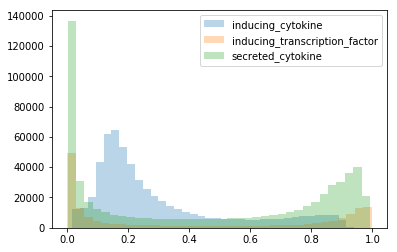

In [25]:
for k, g in df.groupby('type'):
    plt.hist(g['prob'], label=k, bins=36, alpha=.3)
    plt.legend()

In [26]:
df['type'].value_counts()

inducing_cytokine                577866
secreted_cytokine                577866
inducing_transcription_factor    170129
Name: type, dtype: int64

In [155]:
df['ent2_lbl_nrm'].value_counts().sort_values().tail()

Th       60995
Th2     165319
Th1     192991
Th17    206039
Treg    273987
Name: ent2_lbl_nrm, dtype: int64

In [156]:
df['ent2_lbl_nrm'].unique()

array(['Th17', 'Treg', 'Th2', 'Th1', 'Th', 'NKT', 'TEFF', 'iTreg', 'TN',
       'Tc', 'TEM', 'activated T', 'γδT', 'TMEM', 'Treg1', 'Thymocyte',
       'TCM', 'Tr1', 'Th22', 'IEL', 'iNKT', 'Tfh',
       'mature natural killer', 'Tc17', 'Tc9', 'TEMRA', 'γδT-Vδ2', 'Tc1',
       'nTreg', 'Trm', 'iNKT2', 'MAIT', 'Tfreg', 'Tfh17', 'Treg17', 'Th9',
       'decidual natural killer', 'immature natural killer', 'Th3', 'Tc2',
       'type I NK T', 'γδT-Vγ9Vδ2', 'pTreg', 'mature T', 'Tscm',
       'type II NK T', 'mature NK T', 'Th0', 'γδT-Vγ4', 'DETC', 'γδT-17',
       'γδT-Vδ1', 'Tfh1', 'ThP', 'iNKT1', 'Tfh2', 'pre-natural killer',
       'Tc3', 'γδT-Vγ6', 'iNKT17', 'immature T', 'Tc22', 'Tc0', 'αβT',
       'γδT-Vγ5', 'CD16-positive, CD56-dim natural killer',
       'NK1.1-positive natural killer', 'immature NK T', 'γδT-Vγ1',
       'γδT-Vγ2', 'activated type II NK T', 'Tsupp', 'Tfh0', 'γδT-Vγ9',
       'memory regulatory T', 'γδT-TCS1', 'naive regulatory T'],
      dtype=object)

In [149]:
df['ent1_lbl'].value_counts().sort_values().tail()

FOXP3     65216
IL-2      70412
IL-10     80206
IL-4      81618
IFN-γ    140314
Name: ent1_lbl, dtype: int64

In [30]:
# Number of unique cytokines/TFs
df.groupby(['type', 'ent1_lbl']).size().rename('count').reset_index().groupby('type').size()

type
inducing_cytokine                284
inducing_transcription_factor    610
secreted_cytokine                284
dtype: int64

In [31]:
# Number of unique cell types per relation type
df.groupby(['type', 'ent2_lbl']).size().rename('count').reset_index().groupby('type').size()

type
inducing_cytokine                121
inducing_transcription_factor    109
secreted_cytokine                121
dtype: int64

In [32]:
# Number of relations by type
df.query('prob > .5').groupby('type').size()

type
inducing_cytokine                106442
inducing_transcription_factor     71232
secreted_cytokine                287885
dtype: int64

In [194]:
# Number of relations by type (at target thresh)
print(len(df[df['prob'] > pthresh]))
df[df['prob'] > pthresh].groupby('type').size()

283134


type
inducing_cytokine                 35133
inducing_transcription_factor     53656
secreted_cytokine                194345
dtype: int64

In [242]:
# Number of relations per document type (FT vs abstract)

def get_all_doc_data():
    doc_ids = [r[0] for r in session.query(Document.name).all()]
    doc_typs = pd.Series(doc_ids).map(m_doc_ft).map({True: 'Full-Text', False: 'Abstract-Only'})
    assert doc_typs.notnull().all()
    return pd.DataFrame({'doc_id': doc_ids, 'doc_type': doc_typs.tolist()})

# Get all docs and remove those with more than 0 relations
df_zr = get_all_doc_data()
print(len(df_zr))
df_zr = df_zr[~df_zr['doc_id'].isin(df[df['prob'] > pthresh]['doc_id'].unique())]
df_zr = df_zr.drop_duplicates()
df_zr.info()

64274
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39138 entries, 0 to 64273
Data columns (total 2 columns):
doc_id      39138 non-null object
doc_type    39138 non-null object
dtypes: object(2)
memory usage: 917.3+ KB


In [244]:
df.head()

candidate_id       date      doc_id                               ent1_cid  \
0           190 2019-01-01  PMC6320637  CK860050AD3975AB55:CK860050AD3975AB55   
1           191 2019-01-01  PMC6320637  CK860050AD3975AB55:CK860050AD3975AB55   
2           200 2019-01-01  PMC6320637  CKE05E12A50F6849A0:CKE05E12A50F6849A0   
3           117 2017-07-28  PMC5577990  CKF0092985CD6DC797:CKDE858D3F63FD2E03   
4           925 2018-01-01  PMC6141694  CKC07867AD1C55BBD6:CK8F843985B9BF76B8   

  ent1_lbl ent1_text                               ent2_cid  \
0    IL-1α     IL-1α  CTA38F9EDD11BF5D5D:CT919B4FF0A7605265   
1    IL-1α     IL-1α  CTA38F9EDD11BF5D5D:CT919B4FF0A7605265   
2    IL-1β     IL-1β  CTA38F9EDD11BF5D5D:CT919B4FF0A7605265   
3    IL-12     IL-12  CTA38F9EDD11BF5D5D:CT919B4FF0A7605265   
4    IL-10     IL-10  CT1C9B5196D5DC2447:CT3FE60C3FE8E2D0E6   

                                            ent2_lbl ent2_text      prob  \
0                                        T-helper 17      Th17  0.141676   
1                                        T-helper 17      Th17  0.352077   
2                                        T-helper 17      Th17  0.068408   
3                                        T-helper 17      Th17  0.245134   
4  CD4-positive, CD25-positive, alpha-beta regula...      Treg  0.097658   

                type ent2_lbl_nrm  
0  inducing_cytokine         Th17  
1  inducing_cytokine         Th17  
2  inducing_cytokine         Th17  
3  inducing_cytokine         Th17  
4  inducing_cytokine         Treg

In [241]:
def check_doc_type(df):
    assert df['doc_type'].notnull().all()
    return df
    
(
    df
    .pipe(lambda df: df[df['prob'] > pthresh])
    .assign(doc_type=lambda df: df['doc_id'].map(m_doc_ft).map({True: 'Full-Text', False: 'Abstract-Only'}))
    .pipe(check_doc_type)
    # 
    .groupby('doc_type')['doc_id'].agg({'n_relation': 'count', 'n_docs': 'nunique'})
    # Add number of docs with no relations
    .pipe(lambda df: pd.concat([df, df_zr.groupby('doc_type').size().rename('n_z_docs').to_frame()], axis=1, sort=True))
    .pipe(lambda df: df.assign(rel_per_doc=lambda d: d['n_relation'] / (d['n_docs'] + d['n_z_docs'])))
)

/opt/conda/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


n_relation  n_docs  n_z_docs  rel_per_doc
doc_type                                                
Abstract-Only        8520    2395      8570     0.777018
Full-Text          274614   22741     30568     5.151363

<hr>

## Analysis

### Highest/Lowest Probability Examples 

In [60]:
def get_sentence_html(c, p=None, maxlen=256):
    text = c.get_parent().text[:maxlen]
    ctx = sorted(c.get_contexts(), key=lambda v: v.char_start)
    c0 = [ctx[0].char_start, ctx[0].char_end+1]
    c1 = [ctx[1].char_start, ctx[1].char_end+1]
    assert c0[0] <= c1[0] and c0[1] <= c1[0]
    
    for i in range(2):
        for cc in [c0, c1]:
            if cc[i] > maxlen:
                cc[i] = maxlen
    
    col1 = 'blue' if getattr(c, 'immune_cell_type') == ctx[0] else 'red'
    col2 = 'red' if col1 == 'blue' else 'blue'
    
    parts = []
    if p is not None:
        parts += ['<a style="background-color: white; color: green"><strong>{:.2f}%</strong>|&nbsp;</a>'.format(p*100)]
    parts += [
        text[:c0[0]], '<font color="' + col1 + '"><strong>' + text[c0[0]:c0[1]] + '</strong></font>',
        text[c0[1]:c1[0]], '<font color="' + col2 + '"><strong>' + text[c1[0]:c1[1]] + '</strong></font>',
        text[c1[1]:]
    ]
    return ''.join(parts)

In [61]:
# X, Y = res_pred['InducingCytokine'][:2]
# o = np.argsort(Y)[::-1]

In [69]:
from IPython.display import HTML, display

def get_prediction_html(index, ids, probs, limit):
    html = []
    sent_ids = set()
    for i in index:
        cand = session.query(Candidate).filter(Candidate.id == int(ids[i])).one()
        sent_id = cand.get_parent().id
        if sent_id in sent_ids:
            continue
        sent_ids.add(sent_id)
        html.append(get_sentence_html(cand, p=probs[i]))
        if len(html) >= limit:
            break
    return HTML('<br>\n'.join(html))
    
n_cands, limit = 250, 15
res_pred_html = {}
for k, g in df.groupby('type'):
    o = np.argsort(g['prob'])
    res_pred_html[k] = {}
    
    def get_html(idx, l):
        return get_prediction_html(idx, g['candidate_id'].values, g['prob'].values, l)
    
    display(HTML('<hr>'))
    print('%s (Top %s Highest Predictions):' % (k, limit))
    res_pred_html[k]['hi'] = get_html(o[::-1], n_cands)
    display(get_html(o[::-1], limit))
    
    display(HTML('<hr>'))
    print('%s (Mid %s Predictions):' % (k, limit))
    mid = len(o)//2
    res_pred_html[k]['mid'] = get_html(o[(mid-n_cands):(mid+n_cands)], n_cands)
    display(get_html(o[(mid-n_cands):(mid+n_cands)], limit))
    
    display(HTML('<hr>'))
    print('%s (Bottom %s Lowest Predictions):' % (k, limit))
    res_pred_html[k]['lo'] = get_html(o, n_cands)
    display(get_html(o, limit))

inducing_cytokine (Top 15 Highest Predictions):


inducing_cytokine (Mid 15 Predictions):


inducing_cytokine (Bottom 15 Lowest Predictions):


inducing_transcription_factor (Top 15 Highest Predictions):


inducing_transcription_factor (Mid 15 Predictions):


inducing_transcription_factor (Bottom 15 Lowest Predictions):


secreted_cytokine (Top 15 Highest Predictions):


secreted_cytokine (Mid 15 Predictions):


secreted_cytokine (Bottom 15 Lowest Predictions):


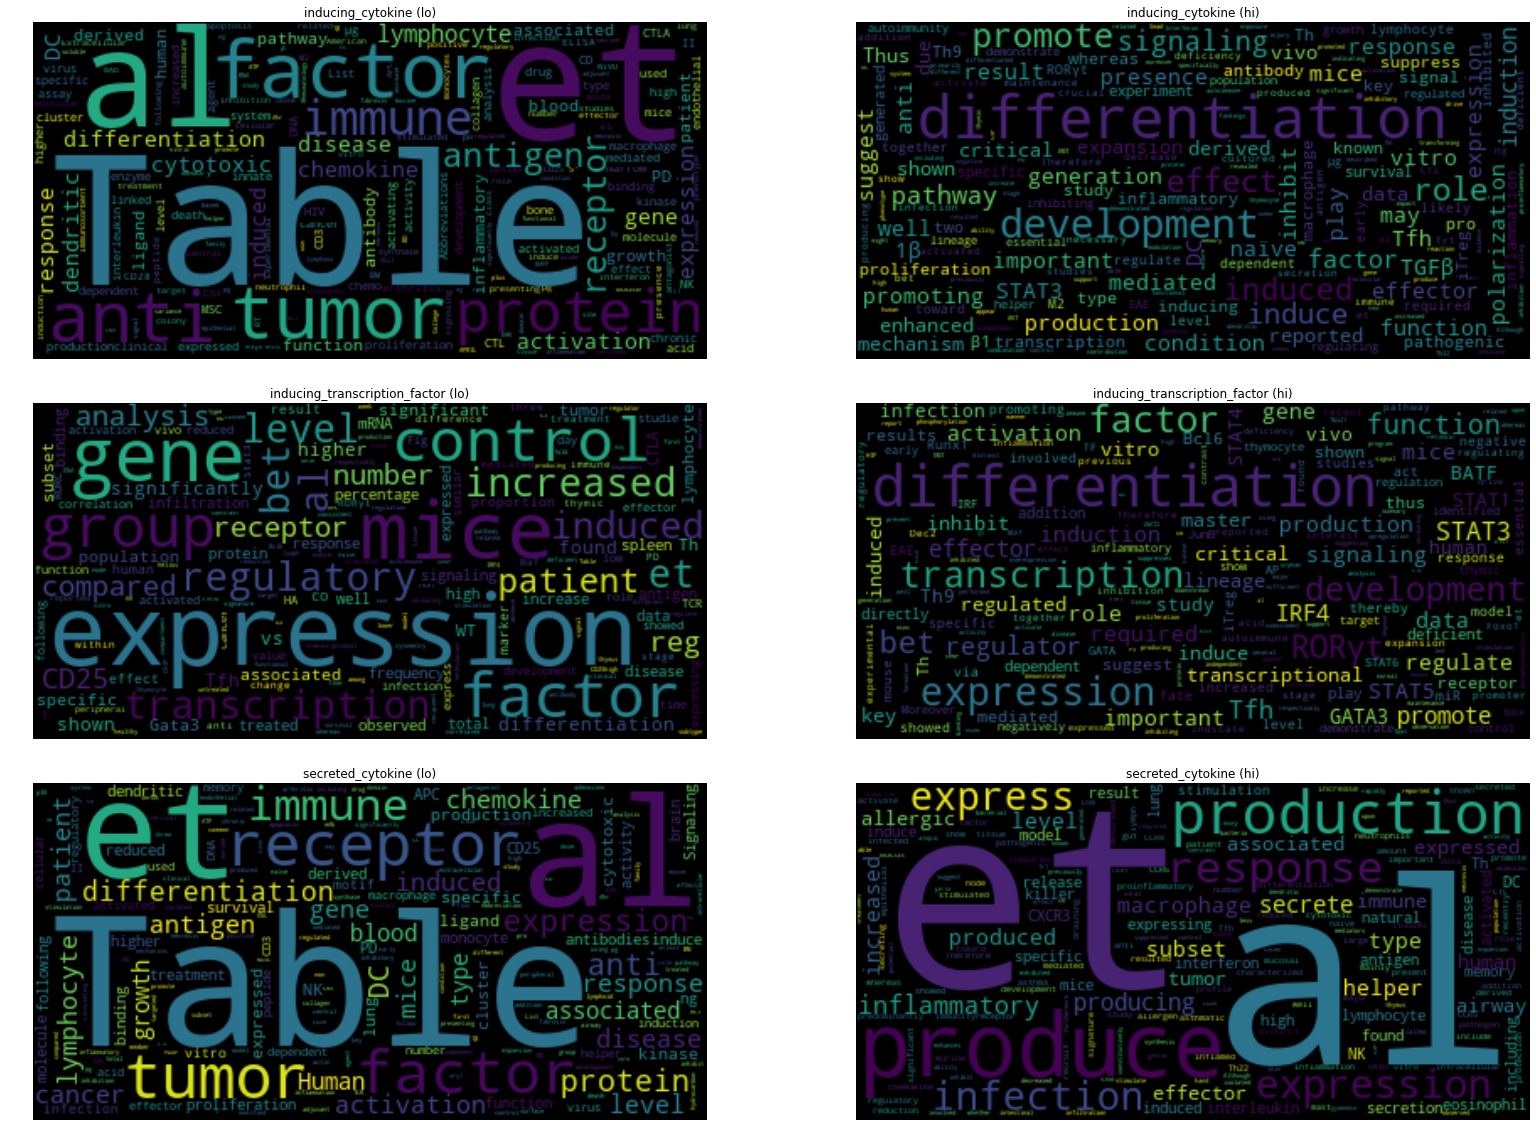

In [71]:
# ! pip install wordcloud  # Install this first to generate these
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import re
#keys = ['lo', 'mid', 'hi']
keys = ['lo', 'hi']
fig, axs = plt.subplots(len(res_pred_html), len(keys))
fig.set_size_inches(12*len(keys), 16)

WC_STOPWORDS = set(list(STOPWORDS) + [
    'cytokine', 'cell', 'cells', 'il', 'Th1', 'Th2', 'Th17', 'ml', 'nkt',
    'cytokines', 'foxp3', 'treg', 'tregs', 'ifn', 'cd4', 'ifnγ', 'γδ',
    'tnf', 'inkt', 'cd8',  'tgf', 'figure', '17a'
])
    
for i, c in enumerate(res_pred_html):
    def add_cloud(j, k):
        text = BeautifulSoup(res_pred_html[c][k].data).get_text()
        wordcloud = WordCloud(collocations=False, stopwords=WC_STOPWORDS, random_state=1).generate(text)    
        axs[i, j].imshow(wordcloud, interpolation='bilinear')
        axs[i, j].axis("off")
        axs[i, j].set_title(c + ' (' + k + ')')
    for j, k in enumerate(keys):
        add_cloud(j, k)
fig.tight_layout()

In [12]:
# from snorkel import viewer
# idx = np.argsort(Y)
# idx = idx[-100:]
# viewer.SentenceNgramViewer(
#     candidates=[X[i] for i in idx], 
#     session=session
# )

### Top Cytokines/TFs by Cell Type

"Enrichment Score": Proportion of papers for a cell type mentioning cytokine/TF divided by same proportion across all **other** cell types

In [157]:
def calculate_scores(df):
    
    def doc_ct(df):
        return df.groupby('ent1_lbl')['doc_id'].nunique().rename('uniq_doc_n')
    
    dfr = []
    for typ in df['type'].unique():
        for ct in df['ent2_lbl_nrm'].unique():
            df_tgt = df[(df['type'] == typ) & (df['ent2_lbl_nrm'] == ct)]
            df_ctx = df[(df['type'] == typ)]
            dfr.append(
                pd.merge(
                    # Unique doc counts for cell type (tgt) by cytokine/TF 
                    # as well as by cytokine/TF for all cell types (ctx)
                    doc_ct(df_ctx).rename('uniq_docn_ctx').reset_index(),
                    doc_ct(df_tgt).rename('uniq_docn_tgt').reset_index(),
                    on='ent1_lbl',
                    how='outer'
                )
                .fillna(0)
                .assign(
                    type=typ, ent2_lbl=ct,
                    # Unique doc count for cell type (tgt) and all cell types (ctx)
                    uniq_docn_ct_ctx=df_ctx['doc_id'].nunique(),
                    uniq_docn_ct_tgt=df_tgt['doc_id'].nunique()
                )
            )
    dfr = pd.concat(dfr, sort=False)
    assert dfr.notnull().all().all()
    dfr['escore'] = (dfr['uniq_docn_tgt'] / dfr['uniq_docn_ct_tgt']) / (dfr['uniq_docn_ctx'] / dfr['uniq_docn_ct_ctx'])
    return dfr
            

dfp = calculate_scores(df[df['prob'] > pthresh])

dfp.head()

ent1_lbl  uniq_docn_ctx  uniq_docn_tgt               type ent2_lbl  \
0     Apo3             11            3.0  inducing_cytokine     Treg   
1     BAFF             27            2.0  inducing_cytokine     Treg   
2     CCL1              2            1.0  inducing_cytokine     Treg   
3    CCL11             12            0.0  inducing_cytokine     Treg   
4    CCL16              1            1.0  inducing_cytokine     Treg   

   uniq_docn_ct_ctx  uniq_docn_ct_tgt    escore  
0              7870              2125  1.010053  
1              7870              2125  0.274336  
2              7870              2125  1.851765  
3              7870              2125  0.000000  
4              7870              2125  3.703529

In [190]:
# Cell type and cytokine counts (after probability thresholding)
for k, g in dfp.groupby('type'):
    print('Type:', k, 'Cell Types:', g['ent2_lbl'].nunique(), 'Proteins:', g['ent1_lbl'].nunique())

Type: inducing_cytokine Cell Types: 75 Proteins: 217
Type: inducing_transcription_factor Cell Types: 75 Proteins: 382
Type: secreted_cytokine Cell Types: 75 Proteins: 262


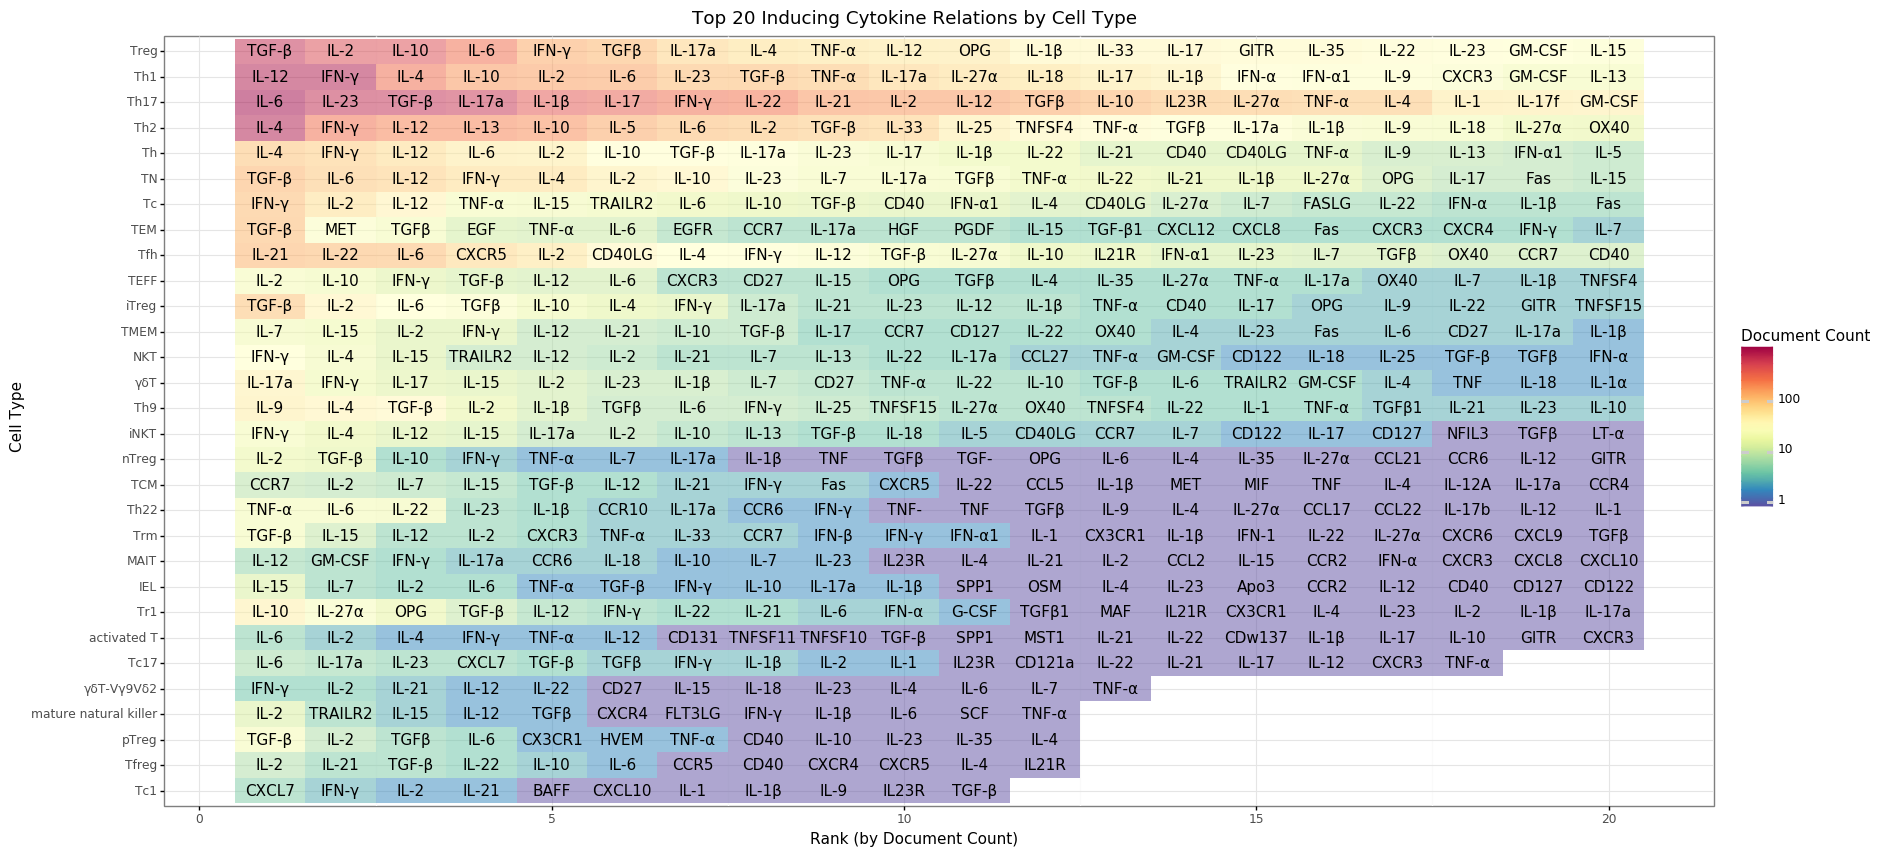

<ggplot: (8793626861516)>

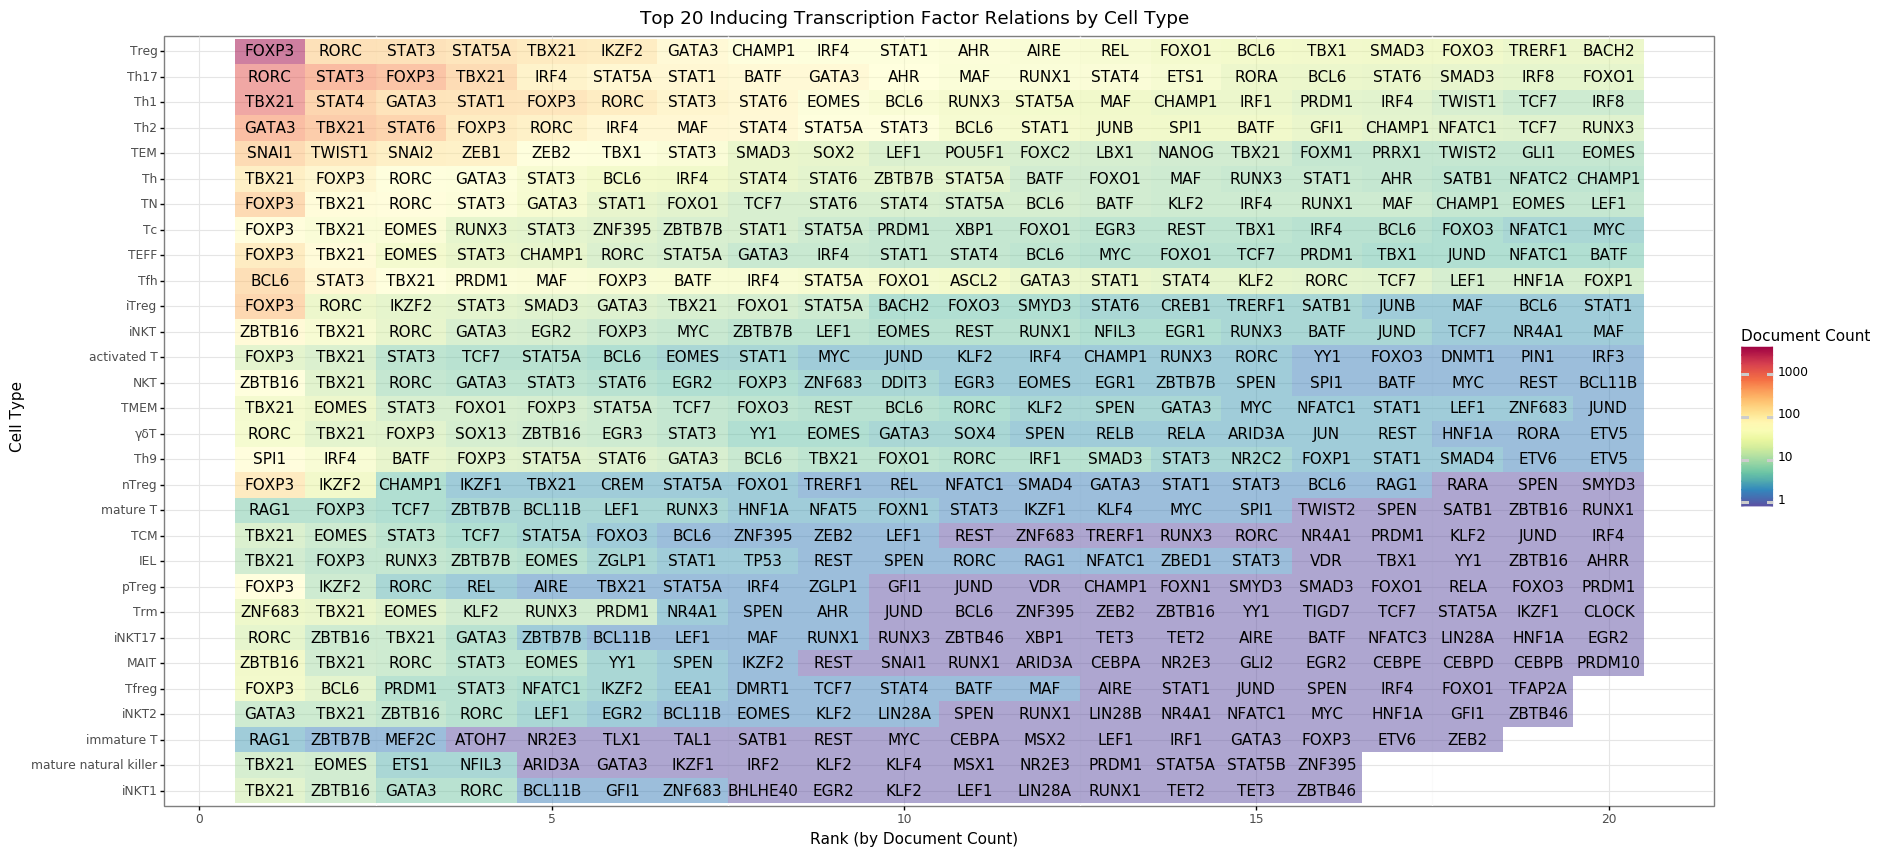

<ggplot: (-9223363243235061977)>

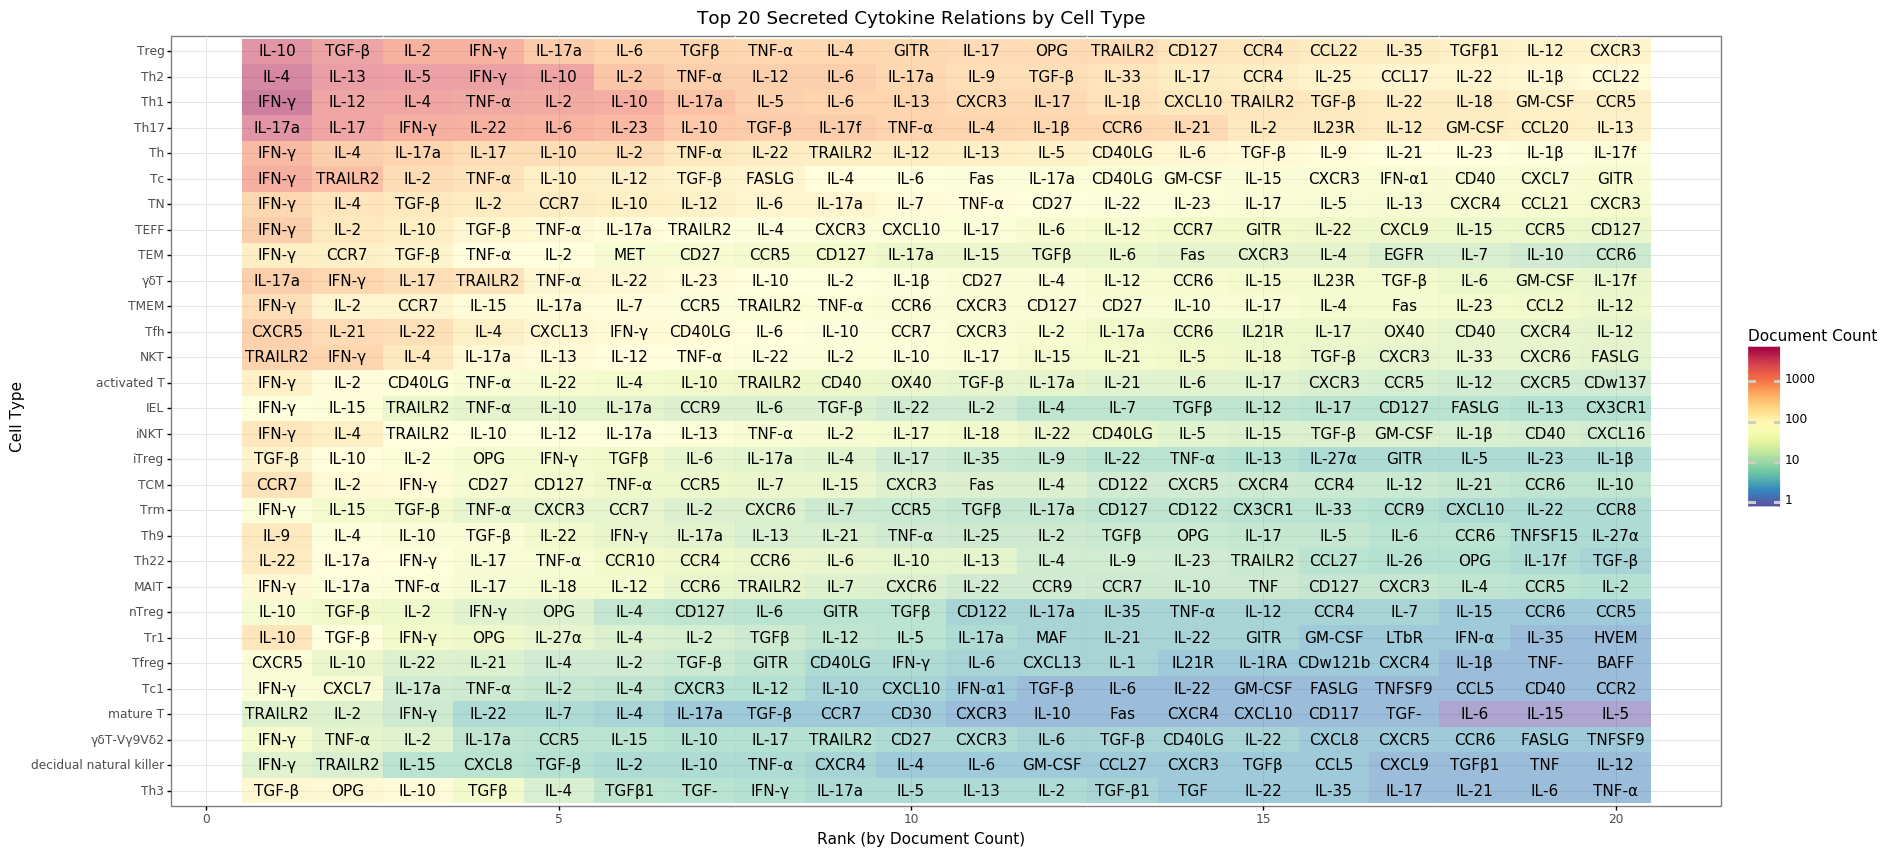

<ggplot: (-9223363243249324796)>

In [164]:
def get_labels(v):
    return [str(int(10**x)) for x in v]


dfhm = (
    dfp
    .pipe(lambda df: df[df['uniq_docn_tgt'] >= 1])
    .pipe(lambda df: df[~df['ent2_lbl'].isin(['Thymocyte'])])
)
for k, g in dfhm.groupby('type'):
    x_limit = 20
    ct_limit = 30
    p = (
        pn.ggplot(
            g
            .assign(uniq_docn_tgt_log=np.log10(g['uniq_docn_tgt']))
            .assign(ent2_lbl=lambda df: pd.Categorical(
                df['ent2_lbl'], categories=df.groupby('ent2_lbl').size().sort_values().index),
                ordered=True
            )
            .pipe(lambda df: df[df['ent2_lbl'].isin(df.groupby('ent2_lbl').size().sort_values().tail(ct_limit).index)])
            .groupby('ent2_lbl').apply(
                lambda g: g.sort_values('uniq_docn_tgt_log', ascending=False)
                .assign(rank=np.arange(1, len(g)+1)).head(x_limit)
            ),
            pn.aes(x='rank', y='ent2_lbl', fill='uniq_docn_tgt_log', label='ent1_lbl')
        ) + 
        pn.geom_tile(alpha=.5) +
        pn.labs(
            title='Top {} {} Relations by Cell Type'.format(x_limit, k.replace('_', ' ').title()), 
            fill='Document Count', x='Rank (by Document Count)', y='Cell Type'
        ) +
        pn.scale_fill_cmap('Spectral_r', labels=get_labels) +
        pn.geom_text(color='black', alpha=1) +
        pn.theme_bw() + 
        pn.theme(figure_size=(20, 10))
    )
    display(p)

In [95]:
# def plot_opposing(df, cell_type, limit=20):
#     type_names = [classes.inducing_cytokine.field, classes.secreted_cytokine.field]
#     df = df[df['type'].isin(type_names)].copy()
#     df = df[df['ent2_lbl'] == cell_type].rename(columns={'uniq_docn_tgt': 'count'})
#     df = df.pivot(index='ent1_lbl', columns='type', values='count')
#     df = df.rename(columns=lambda c: c.replace('_cytokine', ''))
#     total = df.sum().sum()
#     cols = df.columns
#     df['total'] = df.sum(axis=1)
#     df['score'] = 100 * ((df['inducing'] / total) - (df['secreted'] / total))
#     df = df.reset_index().fillna(0)
#     vals = df.set_index('ent1_lbl')['score'].abs().sort_values().tail(limit).index
#     df = df[df['ent1_lbl'].isin(vals)]
#     df['ent1_lbl'] = pd.Categorical(df['ent1_lbl'], categories=df.sort_values('score')['ent1_lbl'], ordered=True)
#     df['sign'] = (df['score'] > 0).map({True: 'Induction', False: 'Secretion'})
#     return (
#         pn.ggplot(df, pn.aes(x='ent1_lbl', y='score', fill='sign')) +
#         pn.geom_bar(stat='identity') + 
#         pn.coord_flip() + 
#         pn.theme_bw() + 
#         pn.scale_fill_cmap_d('Set1') + 
#         pn.labs(title=cell_type, y='(-) Secrection ↔ Induction (+)\n% Net Frequency', x='Cytokine') + 
#         pn.theme(figure_size=(3, 6))
#     )

# display(plot_opposing(dfp, 'T-helper 1'))
# display(plot_opposing(dfp, 'Th9'))
# display(plot_opposing(dfp, 'Th17'))
# display(plot_opposing(dfp, 'Th22'))
# display(plot_opposing(dfp, 'Treg'))

In [47]:
# for k, g in dfp.groupby('type'):
#     p = (
#         pn.ggplot(g, pn.aes(x='ent1_lbl', y='uniq_doc_ct')) + 
#         pn.geom_bar(stat='identity', alpha=.3) +
#         pn.facet_wrap('~ ent2_lbl', scales='free', ncol=3, shrink=False) + 
#         pn.labs(title=k) + 
#         pn.coord_flip() +
#         pn.theme_bw() +
#         pn.theme(
#             axis_text_x = pn.element_text(angle = 90, hjust = 0),
#             figure_size=(16, 24)
#         )
#     )
#     display(p)

## Incoming vs Outgoing Cytokines

In [165]:
#assert df.groupby(['type', 'ent1_lbl', 'ent2_lbl']).size().max() == 1
df.head()

candidate_id       date      doc_id                               ent1_cid  \
0           190 2019-01-01  PMC6320637  CK860050AD3975AB55:CK860050AD3975AB55   
1           191 2019-01-01  PMC6320637  CK860050AD3975AB55:CK860050AD3975AB55   
2           200 2019-01-01  PMC6320637  CKE05E12A50F6849A0:CKE05E12A50F6849A0   
3           117 2017-07-28  PMC5577990  CKF0092985CD6DC797:CKDE858D3F63FD2E03   
4           925 2018-01-01  PMC6141694  CKC07867AD1C55BBD6:CK8F843985B9BF76B8   

  ent1_lbl ent1_text                               ent2_cid  \
0    IL-1α     IL-1α  CTA38F9EDD11BF5D5D:CT919B4FF0A7605265   
1    IL-1α     IL-1α  CTA38F9EDD11BF5D5D:CT919B4FF0A7605265   
2    IL-1β     IL-1β  CTA38F9EDD11BF5D5D:CT919B4FF0A7605265   
3    IL-12     IL-12  CTA38F9EDD11BF5D5D:CT919B4FF0A7605265   
4    IL-10     IL-10  CT1C9B5196D5DC2447:CT3FE60C3FE8E2D0E6   

                                            ent2_lbl ent2_text      prob  \
0                                        T-helper 17      Th17  0.141676   
1                                        T-helper 17      Th17  0.352077   
2                                        T-helper 17      Th17  0.068408   
3                                        T-helper 17      Th17  0.245134   
4  CD4-positive, CD25-positive, alpha-beta regula...      Treg  0.097658   

                type ent2_lbl_nrm  
0  inducing_cytokine         Th17  
1  inducing_cytokine         Th17  
2  inducing_cytokine         Th17  
3  inducing_cytokine         Th17  
4  inducing_cytokine         Treg

In [166]:
dfio_paper_thresh = 10
dfio = (
    df
    .pipe(lambda df: df[df['prob'] > .5])
    .pipe(lambda df: df[~df['type'].isin([classes.inducing_transcription_factor.field])])
    .groupby(['type', 'ent1_lbl', 'ent2_lbl'])['doc_id'].nunique().rename('count').reset_index()
    .pipe(lambda df: df[df['count'] >= dfio_paper_thresh])
)
dfioct = (
    dfio
    .groupby(['type', 'ent1_lbl'])['ent2_lbl'].nunique().unstack(level=0)
    .fillna(0).reset_index().rename(columns={
        classes.inducing_cytokine.field: 'inducing',
        classes.secreted_cytokine.field: 'secreting',
        'ent1_lbl': 'cytokine'
    })
)
dfioct.head()

type cytokine  inducing  secreting
0        Apo3       0.0        1.0
1        BAFF       2.0        3.0
2        CCL1       0.0        2.0
3       CCL11       1.0        2.0
4       CCL17       3.0        8.0

Correlation: (0.9267397134874767, 3.1565876015858675e-65)


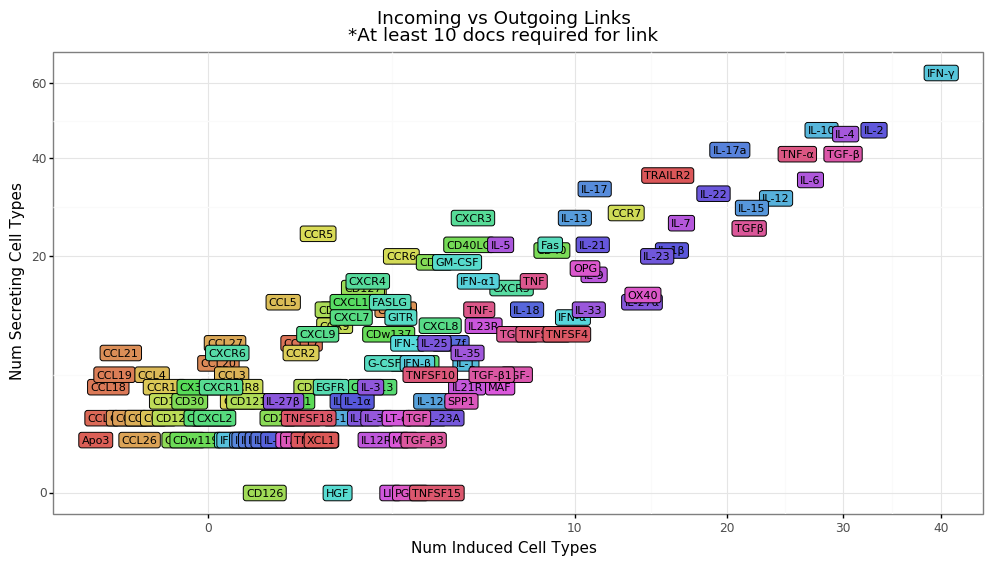

<ggplot: (8793615189887)>

In [167]:
from scipy.stats import pearsonr
# Show pearson r which in immuneXpresso paper was about .69 when created
# using the links from a reference textbook and .86 when looking at 
# automatic link determination
print('Correlation:', pearsonr(dfioct['inducing'], dfioct['secreting']))
(
    pn.ggplot(dfioct, pn.aes(x='inducing', y='secreting', fill='cytokine', label='cytokine')) + 
    pn.geom_label(size=8, position=pn.position_dodge(width=2)) + 
    pn.guides(fill=False) + 
    pn.scale_x_sqrt() +
    pn.scale_y_sqrt() +
    pn.theme_bw() +
    pn.theme(figure_size=(12, 6)) +
    pn.labs(
        x='Num Induced Cell Types', y='Num Secreting Cell Types', 
        title='Incoming vs Outgoing Links\n*At least {} docs required for link'.format(dfio_paper_thresh)
    )
)

## Specific Cytokines/TFs

In [88]:
# (
#     dfp
#     .pipe(lambda df: df[df['ent1_lbl'] == 'IL-32'])
#     .query('uniq_docn_tgt > 0')
#     .sort_values('escore', ascending=False)
# )

In [85]:
# from snorkel.models import Candidate
# cand_ids = list(df[df['ent1_lbl'] == 'IL-32'].query('prob >= .5')['candidate_id'].unique())
# np.array(cand_ids)

In [86]:
# cands = session.query(Candidate).filter(Candidate.id.in_([
# 88745,  88796,  89086,  95335, 213927, 215156, 251138, 251140,
# 251232, 251233, 251270, 252573, 113600, 115029, 115080, 115368,
# 115369, 115370, 116335, 117667, 117668, 123185, 123186, 124532,
# 315753, 334791, 365980, 366096, 366275, 367971, 367972, 368124
# ])).all()
# cands[:3]

In [87]:
# from snorkel import viewer
# viewer.SentenceNgramViewer(cands, session)

## Evolution over Time

In [84]:
(df.query('prob > .5 & ent2_lbl == "Th17" & type == "inducing_cytokine"')
.groupby(['ent1_lbl', pd.Grouper(key='date', freq='1Q')])['doc_id'].nunique()
.rename('count').reset_index()
.head())

ent1_lbl       date  count
0     BAFF 2014-03-31      1
1     CCR6 2014-03-31      1
2    CD132 2017-03-31      1
3     CD40 2016-03-31      1
4   CD40LG 2011-12-31      1

In [413]:
### Plot over time for a single cell type + relation type

# def remove_small_groups(df):
#     # Get number of distinct dates for each cytokine/TF and limit
#     # to remove those with sparse timelines
#     cts = df.groupby('ent1_lbl').size() 
#     return df[df['ent1_lbl'].isin(cts[cts > 10].index)]

# (
#     #df.query('prob > .5 & ent2_lbl == "Th17" & type == "secreted_cytokine"')
#     #df.query('prob > .5 & ent2_lbl == "Th17" & type == "inducing_cytokine"')
#     df.query('prob > .5 & ent2_lbl == "Th17" & type == "inducing_transcription_factor"')
#     #df.query('prob > .5 & ent2_lbl == "γδT" & type == "secreted_cytokine"')
#     .groupby(['ent1_lbl', pd.Grouper(key='date', freq='1Q')])['doc_id'].nunique()
#     .rename('count').reset_index()
#     .pipe(remove_small_groups)
#     .pivot(index='date', columns='ent1_lbl', values='count')
#     .fillna(0)
#     .plot(figsize=(16,36), subplots=True, sharey=False)
# )
# None

### Tags Only

**IMPORTANT**: This section doesn't consider relations/candidates, just raw tags

In [250]:
# Load raw tags and filter to only cell type mentions
dft = pd.read_csv(osp.join(REPO_DATA_DIR, 'results', 'tags.csv.gz'))
dft = dft[dft['type'] == supervision.ENT_TYP_CT]
dft = dft[dft['ent_src'] == 'lkp']
dft['date'] = dft['id'].map(m_doc_dt)
dft = dft.rename(columns={'id': 'doc_id'})
dft.head()

end_chr  end_wrd              ent_id ent_lbl          ent_prefid ent_src  \
8      1816      312  CTC3A8C3CBC245616A     Th1  CTC3A8C3CBC245616A     lkp   
9      1824      314  CTE7B12DC660323A0E     Th2  CTE7B12DC660323A0E     lkp   
79      399       58  CT58AC91B99EE259CE      Th  CTB7DFCED683E6F0A9     lkp   
80      411       62  CTC3A8C3CBC245616A     Th1  CTC3A8C3CBC245616A     lkp   
86     1606      251  CTC3A8C3CBC245616A     Th1  CTC3A8C3CBC245616A     lkp   

       doc_id  start_chr  start_wrd      text              type       date  
8   PMC100031       1813        311       Th1  IMMUNE_CELL_TYPE 2001-11-01  
9   PMC100031       1821        313       Th2  IMMUNE_CELL_TYPE 2001-11-01  
79  PMC101751        391         57  T-helper  IMMUNE_CELL_TYPE 2000-07-01  
80  PMC101751        408         61       Th1  IMMUNE_CELL_TYPE 2000-07-01  
86  PMC101751       1603        250       Th1  IMMUNE_CELL_TYPE 2000-07-01

Num total documents with at least one tag: 7638


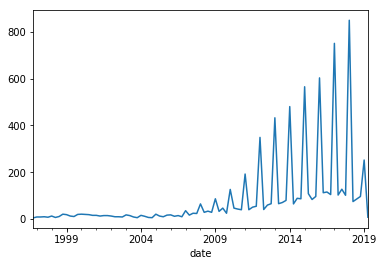

In [251]:
print('Num total documents with at least one tag:', dft['doc_id'].nunique())
dft.groupby(pd.Grouper(key='date', freq='1Q'))['doc_id'].nunique().sort_index().plot()

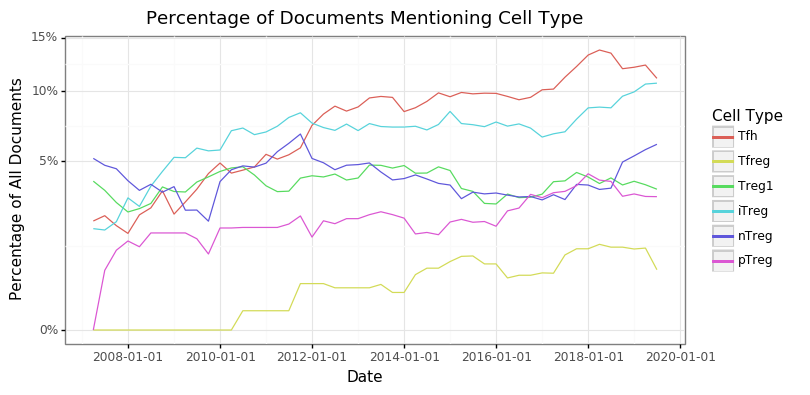

<ggplot: (8793611098344)>

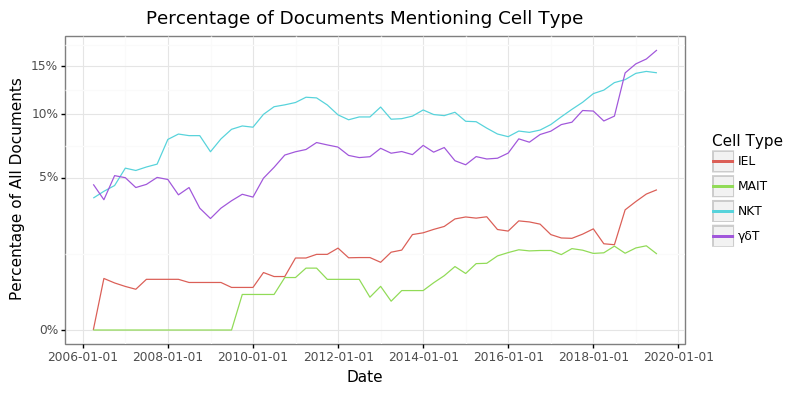

<ggplot: (8793612055956)>

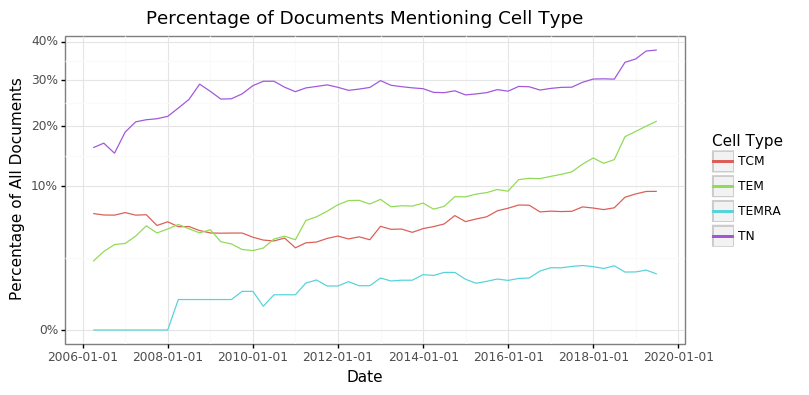

<ggplot: (-9223363243241628868)>

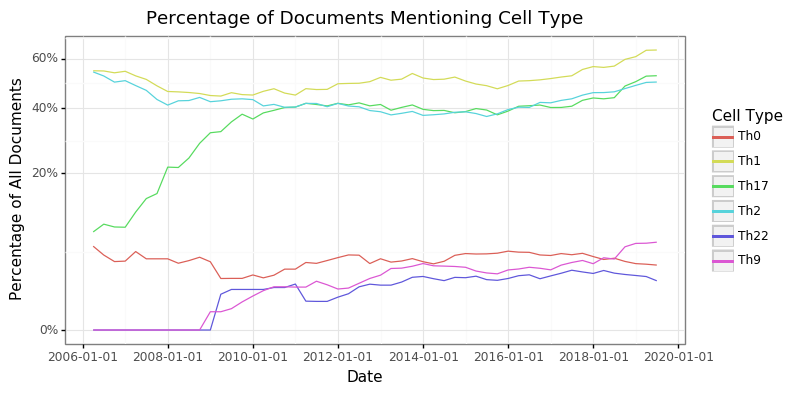

<ggplot: (-9223363243213367692)>

In [252]:
from IPython.display import display

def remove_small_groups(df, limit=10):
    # Get number of distinct dates for each cell type and limit
    # to remove those with sparse timelines
    cts = df.groupby(['ent_lbl', pd.Grouper(key='date', freq='1Q')]).size()\
        .reset_index().groupby('ent_lbl')['date'].nunique()
    return df[df['ent_lbl'].isin(cts[cts >= limit].index)]

def classify_cell_types(df, cell_types=None):
    df = df.copy()
    n = len(df)
    df['ent_lbl'] = np.where(df['ent_lbl'].isin(cell_types), df['ent_lbl'].values, 'Other')
    return df

def plot_mentions_over_time(df, cell_types, limit=0):
    return (
        df
        .pipe(classify_cell_types, cell_types=cell_types)
        .pipe(remove_small_groups, limit=limit)
        .query('date >= "2006-01-01"')
        .pipe(lambda df: (
            df.groupby([pd.Grouper(key='date', freq='1Q'), 'ent_lbl'])['doc_id'].nunique().unstack()
            .div(df.groupby(pd.Grouper(key='date', freq='1Q'))['doc_id'].nunique(), axis='index')
        ))
        .pipe(lambda df: df[[c for c in df if c != 'Other']])
        .dropna(how='all', axis='index') # Drop all NA rows
        .fillna(0)
        .rolling(window=8, min_periods=1, center=True).mean()
        .rename_axis(columns='cell_type')
        .stack().rename('percent').reset_index()
        .pipe(lambda df: (
            pn.ggplot(df, pn.aes(x='date', y='percent', color='cell_type')) +
            pn.geom_line() + 
            pn.theme_bw() + 
            pn.labs(
                title='Percentage of Documents Mentioning Cell Type', x='Date', 
                y='Percentage of All Documents', color='Cell Type') +
            pn.scale_y_sqrt(labels=lambda l: ['{:.0f}%'.format(100*v) for v in l]) + 
            pn.theme(figure_size=(8, 4))
        ))
    )

#display(plot_mentions_over_time(dft, ['Tc', 'Tc1', 'Tc2', 'Tc9', 'Tc0', 'Th']))
display(plot_mentions_over_time(dft, ['Treg1', 'Tfh', 'Tfreg', 'pTreg', 'nTreg', 'iTreg']))
display(plot_mentions_over_time(dft, ['γδT', 'MAIT', 'NKT', 'IEL']))
display(plot_mentions_over_time(dft, ['TCM', 'TEM', 'TN', 'TEMRA']))
display(plot_mentions_over_time(dft, ['Th0', 'Th1', 'Th2', 'Th9', 'Th17', 'Th22']))

## TF clustering

In [23]:
dfp.head()

ent1_lbl  uniq_docn_ctx  uniq_docn_tgt               type ent2_lbl  \
0    4-1BB             21            6.0  inducing_cytokine      Th1   
1   4-1BBL              2            0.0  inducing_cytokine      Th1   
2    APRIL              7            2.0  inducing_cytokine      Th1   
3     CCL1             13            0.0  inducing_cytokine      Th1   
4    CCL11              8            1.0  inducing_cytokine      Th1   

   uniq_docn_ct_ctx  uniq_docn_ct_tgt    escore  
0              4276              2023  0.603912  
1              4276              2023  0.000000  
2              4276              2023  0.603912  
3              4276              2023  0.000000  
4              4276              2023  0.264212

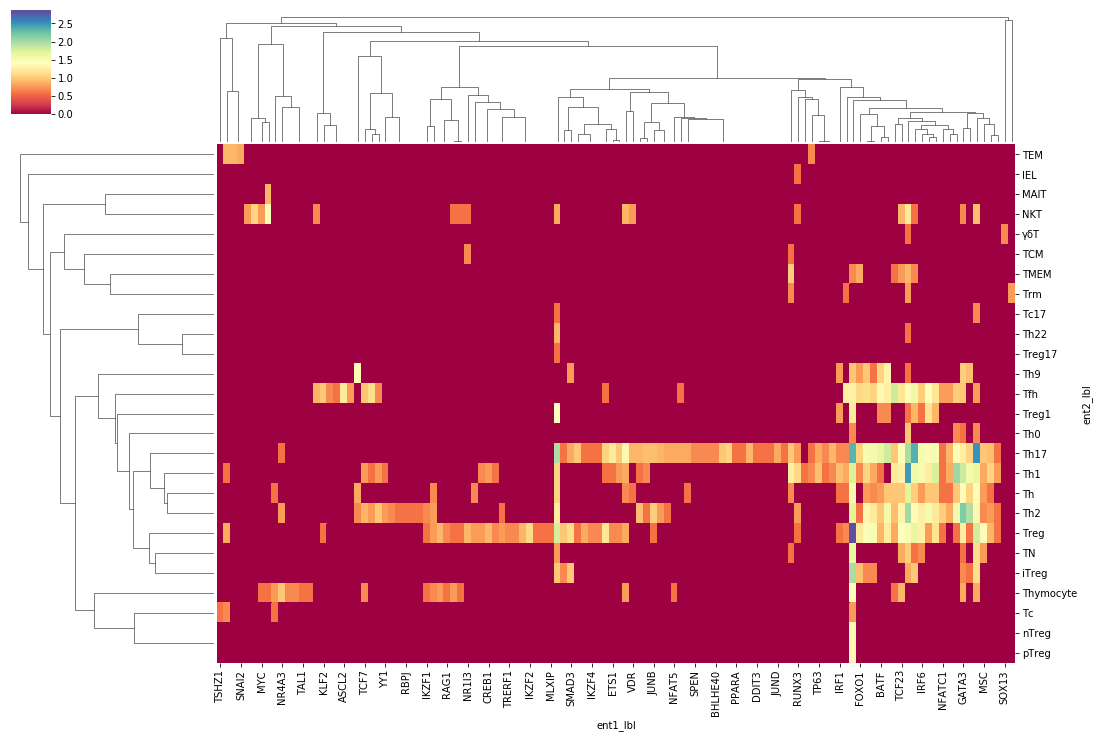

In [24]:
import seaborn as sns

def plot_tf_cluster_heatmap(df):
    df = df[df['type'] == classes.inducing_transcription_factor.field].copy()
    df = df[df['uniq_docn_tgt'] >= 3]
    df = df.pivot(index='ent2_lbl', columns='ent1_lbl', values='uniq_docn_tgt').fillna(0)
    df = np.log10(df + 1)
    return sns.clustermap(df, cmap='Spectral', metric='correlation')
g = plot_tf_cluster_heatmap(dfp)
g.fig.set_size_inches(18, 12)

## ImmuneXpresso Comparison

In [168]:
def get_ix_data():
    df = pd.read_csv(osp.join(SUPERVISION_DATA_DIR, 'immunexpresso', 'data.csv'))
    df['type'] = None
    df['type'] = np.where(
        (df['actor'] == 'cell') & (df['category'] == 'Positive'), 
        classes.secreted_cytokine.field, 
        df['type']
    )
    df['type'] = np.where(
        (df['actor'] == 'cytokine') & (df['category'] == 'Positive'), 
        classes.inducing_cytokine.field, 
        df['type']
    )
    return df[df['type'].notnull()]
df_ix = get_ix_data()
df_ix.head()

actor  category     cell_id                       cell_label  \
0      cell  Positive  CL_0000084                           T cell   
1      cell  Positive  CL_0000084                           T cell   
2      cell  Positive  CL_0000625  CD8-positive, alpha-beta T cell   
3  cytokine  Positive  CL_0000084                           T cell   
5      cell  Positive  CL_0000624  CD4-positive, alpha-beta T cell   

  cytokine_id cytokine_label  num_papers  score cell_ref_id  \
0      CID_83           IFNG         809   4.28         NaN   
1     CID_110            IL2         701   5.30         NaN   
2      CID_83           IFNG         338   8.88         NaN   
3     CID_110            IL2         313   1.58         NaN   
5      CID_83           IFNG         236   5.41         NaN   

      cytokine_ref_id               type  
0  CKEF3883BE9F74024F  secreted_cytokine  
1  CKA3BA887803CF8CE7  secreted_cytokine  
2  CKEF3883BE9F74024F  secreted_cytokine  
3  CKA3BA887803CF8CE7  inducing_cytokine  
5  CKEF3883BE9F74024F  secreted_cytokine

In [176]:
df_comp = pd.merge((
        df
        .pipe(lambda df: df[df['prob'] > pthresh])
        .assign(ent1_cid=lambda df: df['ent1_cid'].str.split(':').str[1])
        .assign(ent2_cid=lambda df: df['ent2_cid'].str.split(':').str[1])
        .groupby(['type', 'ent1_cid', 'ent1_lbl', 'ent2_cid', 'ent2_lbl'])['doc_id'].nunique()
        .rename('n_docs_snkl').reset_index()
    ), (
        df_ix.groupby(['type', 'cell_ref_id', 'cytokine_ref_id'])['num_papers'].max()
        .rename('n_docs_imxp').reset_index()
        .rename(columns={'cytokine_ref_id': 'ent1_cid', 'cell_ref_id': 'ent2_cid'})
    ),
    on=['type', 'ent1_cid', 'ent2_cid'],
    how='outer'
)
df_comp.head()

type            ent1_cid ent1_lbl            ent2_cid  \
0  inducing_cytokine  CK01AA93181DDC203F      HGF  CT16F3976F4D1D92F0   
1  inducing_cytokine  CK01AA93181DDC203F      HGF  CT3CFB613D270E6C62   
2  inducing_cytokine  CK01AA93181DDC203F      HGF  CT3FE60C3FE8E2D0E6   
3  inducing_cytokine  CK01AA93181DDC203F      HGF  CT4EC75AEE8E7F5A03   
4  inducing_cytokine  CK01AA93181DDC203F      HGF  CT919B4FF0A7605265   

                                            ent2_lbl  n_docs_snkl  n_docs_imxp  
0                               induced T-regulatory          1.0          NaN  
1                                         T-helper 2          1.0          NaN  
2  CD4-positive, CD25-positive, alpha-beta regula...          1.0          NaN  
3                                         T-helper 1          2.0          NaN  
4                                        T-helper 17          1.0          NaN

In [185]:
from scipy.stats import pearsonr

def plot_ix_comparison(rel_type):
    df = df_comp.dropna().copy()
    df = df[df['type'] == rel_type]
    r, p = pearsonr(df['n_docs_snkl'], df['n_docs_imxp'])
    if p < 1e-6:
        p = '< 1e-6'
    else:
        p = '= {:.6f}'.format(p)
    print('Num distinct cytokines:', df['ent1_lbl'].nunique())
    print('Num distinct cell types:', df['ent2_lbl'].nunique())
    print('Num distinct pairs:', len(df[['ent1_lbl', 'ent2_lbl']].drop_duplicates()))
    return (
        pn.ggplot(
            df, 
            pn.aes(x='n_docs_snkl', y='n_docs_imxp', color='ent2_lbl')
        ) + 
        pn.geom_point(size=3, alpha=.5) +
        pn.annotate('text', x=3, y=100, label='R = {:.2f} (p {})'.format(r, p)) + 
        pn.labs(
            title='ImmuneXpresso Comparison ({})'.format(rel_type.replace('_', ' ').title()),
            x='Document Count', y='ImmuneXpresso Document Count', color='Cell Type'
        ) + 
        pn.scale_x_log10() +
        pn.scale_y_log10() +
        pn.theme_bw() +
        pn.theme(figure_size=(8,6))
    )

Num distinct cytokines: 24
Num distinct cell types: 20
Num distinct pairs: 84


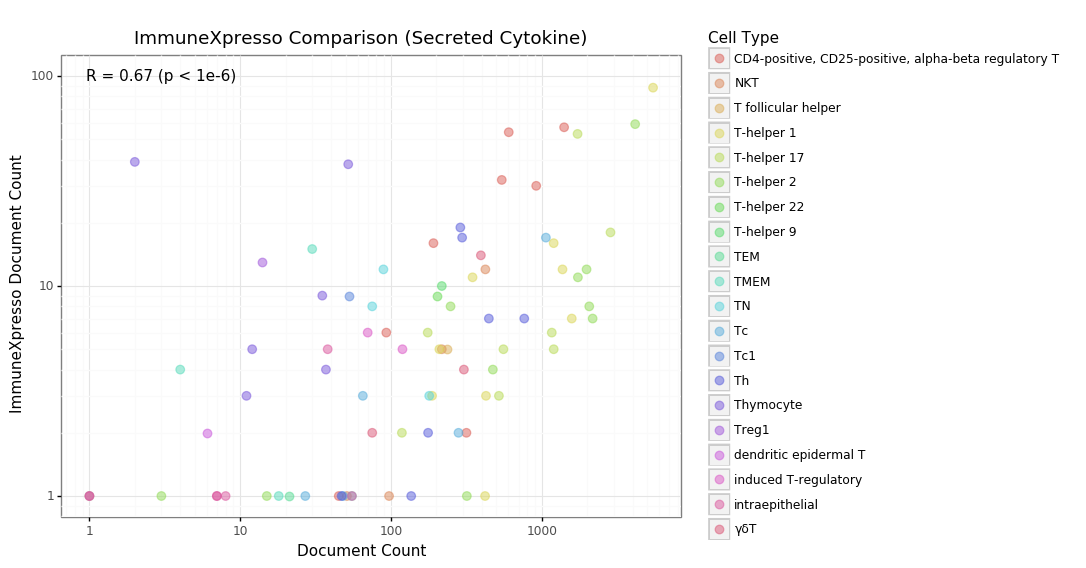

<ggplot: (8793663893217)>

In [186]:
plot_ix_comparison(classes.secreted_cytokine.field)

Num distinct cytokines: 55
Num distinct cell types: 20
Num distinct pairs: 189


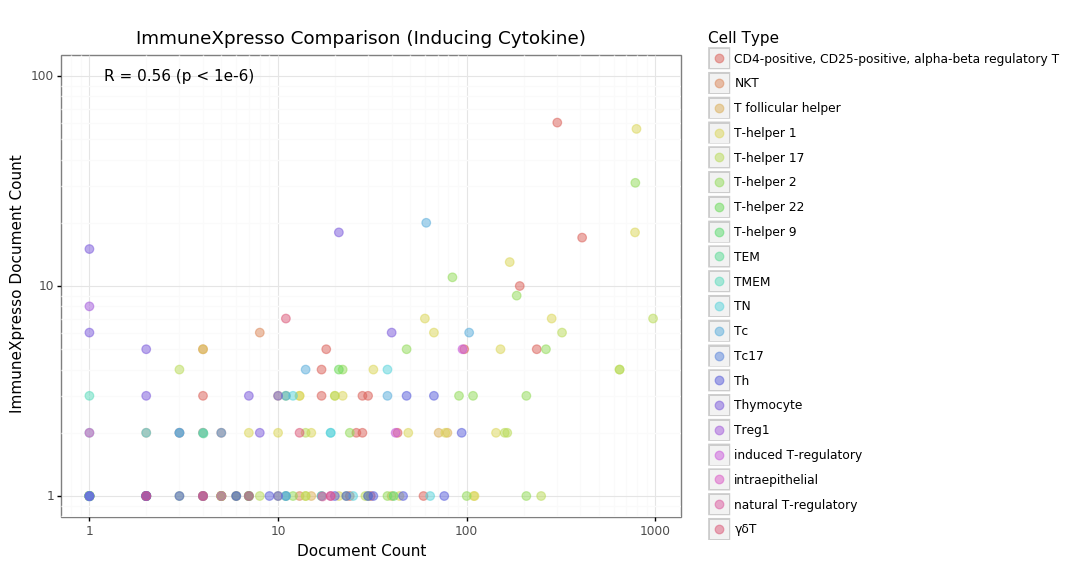

<ggplot: (-9223363243213395000)>

In [187]:
plot_ix_comparison(classes.inducing_cytokine.field)

In [170]:
# import seaborn as sns
# import scipy.stats as stats

# jg = sns.jointplot(
#     'n_docs_snkl', 'n_docs_imxp', 
#     #data=df_comp.dropna().query('type == "inducing_cytokine"'), 
#     data=df_comp.dropna().query('type == "secreted_cytokine"')
#     .assign(n_docs_snkl=lambda df: df['n_docs_snkl'].apply(np.log10))
#     .assign(n_docs_imxp=lambda df: df['n_docs_imxp'].apply(np.log10)), 
#     kind='reg', height=8
# )
# jg.annotate(stats.pearsonr)
# # jg.ax_joint.set_xscale('log')
# # jg.ax_joint.set_yscale('log')

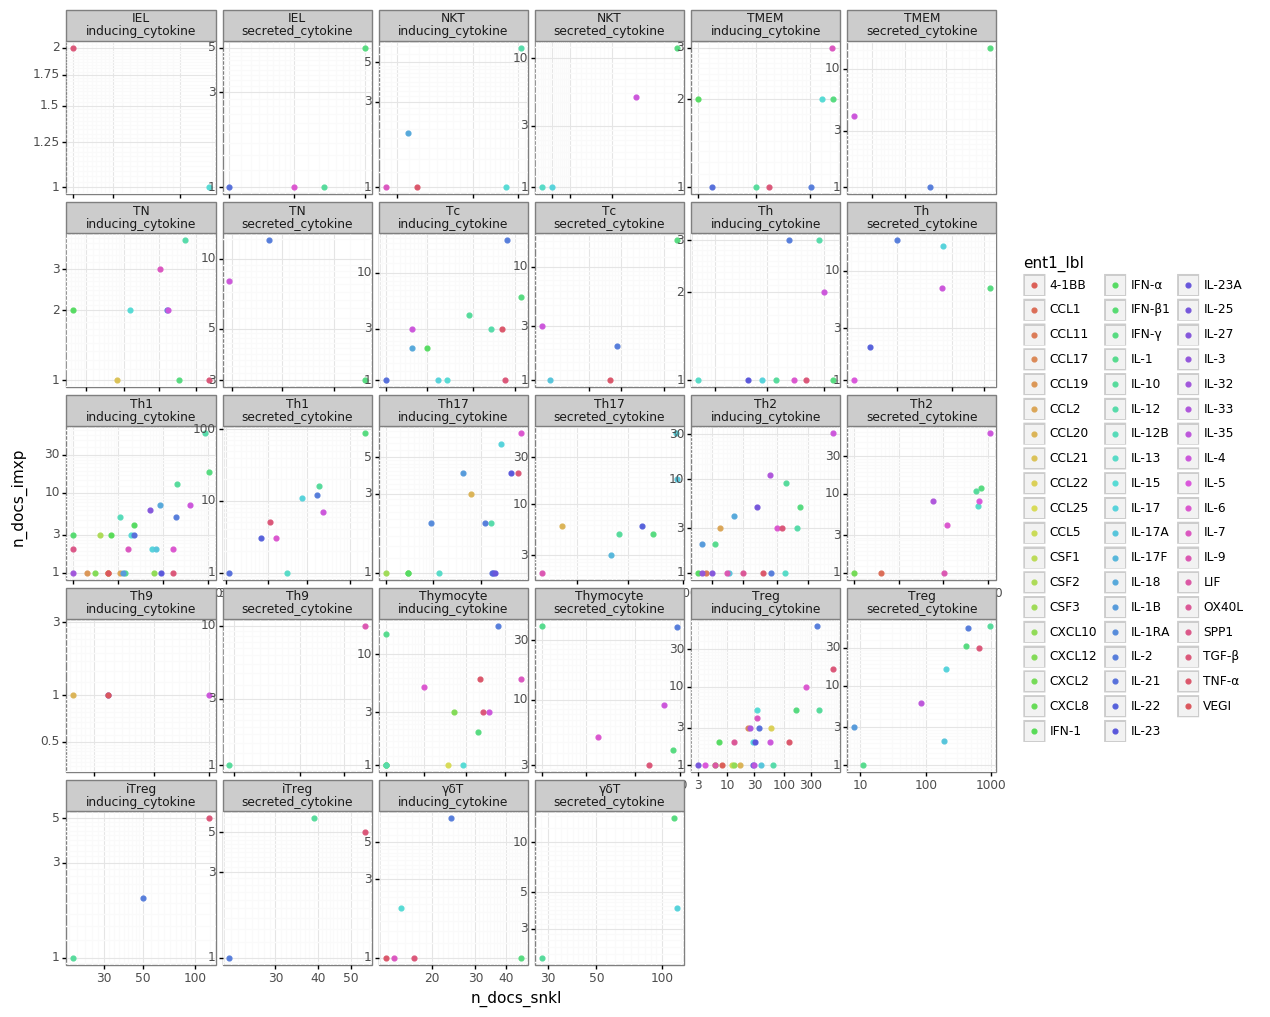

<ggplot: (-9223372036358487815)>

In [137]:
cts = df_comp.dropna().groupby('ent2_lbl').size() 
(
    pn.ggplot(
        df_comp.dropna().pipe(lambda df: df[df['ent2_lbl'].isin(cts[cts > 5].index)]), 
        pn.aes(x='n_docs_snkl', y='n_docs_imxp', color='ent1_lbl')
    ) + 
    pn.geom_point() + 
    pn.facet_wrap('~ ent2_lbl + type', scales='free') + 
    pn.scale_x_log10() +
    pn.scale_y_log10() +
    pn.theme_bw() +
    pn.theme(figure_size=(12,12))
)

### Export Candidates to BRAT

In [41]:
%run ../src/brat.py
collection_dir = osp.join(os.environ['REPO_DATA_DIR'], 'brat', 'viz', 'train_01')
corpus_docs_dir = osp.join(os.environ['DATA_DIR'], 'articles', 'corpus', 'corpus_00', 'links')
collection_dir, corpus_docs_dir

('/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/brat/viz/train_01',
 '/Users/eczech/data/research/hammer/nlp/20190311-pubmed-tcell-relation/articles/corpus/corpus_00/links')

<Figure size 432x288 with 0 Axes>

In [42]:
def relation_type_fn(c, i, ents):
    proba = Y[i] 
    if proba < .2:
        return c.type + '_low'
    if proba < .8:
        return c.type + '_mid'
    return c.type + '_high'

def text_loader_fn(doc_id):
    with open(osp.join(corpus_docs_dir, doc_id + '.txt')) as fd:
        return fd.read()

In [44]:
bcol = snorkel_candidates_to_brat_collection(
    X, candidate_class.subclass, text_loader_fn, relation_type_fn=relation_type_fn)

In [45]:
bcol.export(collection_dir, styles={
    candidate_class.field + '_low': 'color:red',
    candidate_class.field + '_mid': 'color:orange',
    candidate_class.field + '_high': 'color:green'
}, include_entity_text=False)